Welcome!

Check the pdf "Matching VBF-quarks with Jets" before to know some background and purpose for this code. You should know what is bGenPart (best GenPart), bGenJet and bJet, etc.

This "main.ipynb" python file is the main file. You can "Restart & Run All", but this code can do many different things. The function- and variable definion -files can be always run with %run command.

But there are few things that can be done after that;

    1) study histograms of different variables (you can use my histogram functions or it may easier to make own functions),
    2) print and study the matchings (bGenPart-->bGenJet-->bJet) results (the "printStats" -files and functions),
    3) print and study the events one by one and print interesting properties about it (the "printEvents" stuff),
    4) improve finding of the VBF jets with detector data towards "strong Jets" using pandas dataframe, and sklearn machine learning algorithms.
    
I recommend studying the code below well enough before "Restart & Run All". Use might want to study only one of the four things listed above and comment out the other %run and %load commands.

Notice that the dataset events can be filtered by (at least) two ways: fatJetFilter (loose filter) and viljaFilter (SalomaaMod recommended).

# -------------------------------------

###### All NanoAOD v7 variables are listed here: https://cms-nanoaod-integration.web.cern.ch/integration/master/mc94X_doc.html#LHE
###### List of all custom NanoAODv7 files is at: https://cmsweb.cern.ch/das/request?view=list&limit=150&instance=prod%2Fphys03&input=%2F*%2F*-NanoTuples-30Apr2020_*%2FUSER

# -------------------------------------

## All imports:

In [1]:
# Time is imported for checking the runtime

import time
t_init = time.time()

In [2]:
import ROOT

Welcome to JupyROOT 6.24/00


In [3]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

from ROOT import TLine

import sklearn as sk

In [4]:
# Batch mode (do not open windows while running)
ROOT.gROOT.SetBatch(True)

# Enable multi-threading with 4 threads 
#ROOT.ROOT.EnableImplicitMT(4)

# Choose the dataset and filtering of the events.

In [5]:
# Choose the dataset and filtering of the events. You can delete this and make own (better/simpler) method of choosing the data if you want.
# Look up the next cells to know wat these "flags" actually do.
# Here the data is "chosen" and after this the code uses if-functions to handle and make the dataframe.
# HH = di-Higgs data and WW = di-W-boson data (tt and ll is the polarisation of the bosons)
#********************************
# Datafile (choose one and specify if needed, f.ex. WW = True and WW_tt = True)
#--------------------------------
HH = True
#--------------------------------
WW = False

WW_ll = False
WW_tt = False
#********************************
# Filters (choose one):
#--------------------------------
fatJetFiltered = False
#--------------------------------
viljaFiltered=True

# These are modifications of the original viljaFilter.
# LaurilaMod has looser filters
# SalomaaMod has more variables but same filters (I recommend using this)

viljaFiltered_original = False
viljaFiltered_LaurilaMod = False
viljaFiltered_SalomaaMod = True
#********************************
# How much data (you can ignore or delete these if you want):
#--------------------------------
HH_one = False
viljaFilteredFromAll = False
#--------------------------------
bigData = False
allData = False

# Create dataframe from NanoAOD files:

In [6]:
# Some information of the datafiles:
#********************************
# HH file path:
# /eos/cms/store/cmst3/group/vhcc/nanoTuples/v2_30Apr2020/2018/mc/VBF_HH_CV_1_C2V_0_C3_1_dipoleRecoilOff-TuneCP5_PSweights_13TeV-madgraph-pythia8/NanoTuples-30Apr2020_RunIIAutumn18MiniAOD-102X_v15-v2/200601_133715/0000/

# FILE CODE: VBF HH CV 1 C2V 0 C3 1 dipoleRecoilOff-TuneCP5 PSweights 13TeV-madgraph-pythia8 0.009169
#--------------------------------
# WW_ll file path:
# /eos/cms/store/cmst3/group/vhcc/nanoTuples/v2_30Apr2020/2016/mc/WWjj_SS_ll_hadronicMG272_WPt200Inf/NanoTuples-30Apr2020_kirschen-FullSim_94X-2016-MINIAODSIM-bd3e7bcff6c9bcad356ea4ed7e4f08b4/210708_131326/0000/
#--------------------------------
# WW_tt file path:
# /eos/cms/store/cmst3/group/vhcc/nanoTuples/v2_30Apr2020/2016/mc/WWjj_SS_tt_hadronicMG272_WPt200Inf/NanoTuples-30Apr2020_kirschen-FullSim_94X-2016-MINIAODSIM-bd3e7bcff6c9bcad356ea4ed7e4f08b4/210708_131251/0000/
#********************************
# If "the file is not found" use this in front of the path:
# root://xrootd-cms.infn.it/
#********************************

if HH:
    
    chain = ROOT.TChain('Events')

    path = '/eos/cms/store/cmst3/group/vhcc/nanoTuples/v2_30Apr2020/2018/mc/'
    path += 'VBF_HH_CV_1_C2V_0_C3_1_dipoleRecoilOff-TuneCP5_PSweights_13TeV-madgraph-pythia8/'
    path += 'NanoTuples-30Apr2020_RunIIAutumn18MiniAOD-102X_v15-v2/200601_133715/0000/'
    
    # These determine how much data you want. You can tweak these easily here if you want.
    if HH_one:
        r = range(1,2,1)
    elif viljaFilteredFromAll:
        r = range(1, 120, 1)
    elif viljaFiltered:
        r = range(1, 13, 1)
    elif fatJetFiltered:
        r = range(1, 17, 1)
    else:
        r = range(1,2,1)
    for i in r:
        path_i = path + 'nano_' + str(i) + '.root'
        chain.AddFile(path_i)
    
elif WW:
    
    chain = ROOT.TChain('Events')
    
    path = '/eos/cms/store/cmst3/group/vhcc/nanoTuples/v2_30Apr2020/2016/mc/'
    
    # Here also you can choose the amount of the data.
    if WW_ll:
        path += 'WWjj_SS_ll_hadronicMG272_WPt200Inf/'
        path += 'NanoTuples-30Apr2020_kirschen-FullSim_94X-2016-MINIAODSIM-bd3e7bcff6c9bcad356ea4ed7e4f08b4/210708_131326/0000/'
        for i in range(1, 501, 1):
            path_i = path + 'nano_' + str(i) + '.root'
            chain.AddFile(path_i)
    elif WW_tt:
        path += 'WWjj_SS_tt_hadronicMG272_WPt200Inf/'
        path += 'NanoTuples-30Apr2020_kirschen-FullSim_94X-2016-MINIAODSIM-bd3e7bcff6c9bcad356ea4ed7e4f08b4/210708_131251/0000/'
        for i in range(1, 206, 1):
            path_i = path + 'nano_' + str(i) + '.root'
            chain.AddFile(path_i)
            if i == 1:
                print(path_i)

df = ROOT.RDataFrame(chain)

## FindClosest (c++ code):

In [7]:
# You should always run this (define functions)

%run findClosestFunctions.py

## bGenPart (c++ code):

In [8]:
# You should always run this (define functions)

%run bGenPartFunctions.py

# -------------------------------------

# Time to filter the data df --> df0 (1/2):

In [9]:
#*************************************
# fatJetFiltered:

# Filter dataframe to contain >= two (>400 pt fat jets) with one over 500 pt
# Select only events with at least two AK8 jets
#-------------------------------------
# viljaFiltered:

# First use the viljaFilter
# Then use events with GenJets and Jets
# Then use only strong events
#*************************************

if fatJetFiltered:
    df_cut_nak8 = df.Filter('nFatJet >= 2', 'Events with >=2 AK8 jets')
    df_cut_ak8pt = df_cut_nak8.Filter('Sum(FatJet_pt > 400.0) >= 2', 'Events with >=2 AK8 jets with pT > 400 GeV')
    df_cut_leadingak8pt = df_cut_ak8pt.Filter('Sum(FatJet_pt > 500.0) > 0', 'Events with >=1 AK8 jets with pT > 500 GeV')
    df_cut_leadingak8pt.Report().Print()
    df0 = df_cut_leadingak8pt
elif viljaFiltered:
    #-------------------------------------
    if viljaFiltered_original:
        %run viljaFilter.py
    elif viljaFiltered_LaurilaMod:
        %run viljaFilter_LaurilaMod.py
    elif viljaFiltered_SalomaaMod: 
        %run viljaFilter_SalomaaMod.py
    #-------------------------------------
    if HH_one:
        df_viljaFiltered = filtersAndcuts(df, 36000, 0.009169)
    elif viljaFiltered and (not viljaFilteredFromAll):
        df_viljaFiltered = filtersAndcuts(df, 292000, 0.009169)
    #-------------------------------------
    # filtering will continue soon...
    #-------------------------------------
else:
    df0 = df

Warning in <TClass::Init>: no dictionary for class edm::Hash<1> is available
Warning in <TClass::Init>: no dictionary for class edm::ProcessHistory is available
Warning in <TClass::Init>: no dictionary for class edm::ProcessConfiguration is available
Warning in <TClass::Init>: no dictionary for class edm::ParameterSetBlob is available
Warning in <TClass::Init>: no dictionary for class pair<edm::Hash<1>,edm::ParameterSetBlob> is available
Warning in <TClass::Init>: no dictionary for class __pair_base<edm::Hash<1>,edm::ParameterSetBlob> is available


#### Define bGenPart, bGenJet and bJet variables:

In [10]:
# You should always run this (define variables using the functions defined above)

%run def_bVariables.py

if not viljaFiltered:
    df0 = defbVariables(df0)
else:
    df_viljaFiltered_with_bVariables = defbVariables(df_viljaFiltered)

# Filtering using nB_strong (2/2):

In [11]:
#-------------------------------------
# ... filtering continues:

if viljaFiltered:
    df_viljaFiltered_with_GenJets_Jets = df_viljaFiltered_with_bVariables.Filter('nGenJet >= 2', 'Events with >= 2 nGenJets')
    df_viljaFiltered_strong = df_viljaFiltered_with_GenJets_Jets.Filter('nB_strong == 2', 'Events with strong matched VBF jets')
    df_viljaFiltered_strong_sep = df_viljaFiltered_strong.Filter('bJet_eta[0] != bJet_eta[1]', 'Events with different bJets')
    df_viljaFiltered_strong_sep.Report().Print()
    df0 = df_viljaFiltered_strong_sep
#-------------------------------------

Events with >=2 AK8 jets: pass=119845     all=292000     -- eff=41.04 % cumulative eff=41.04 %
Preselection of subleading jet pt: pass=75527      all=119845     -- eff=63.02 % cumulative eff=25.87 %
Preselection of leading jet pt: pass=62550      all=75527      -- eff=82.82 % cumulative eff=21.42 %
Events passing at least one trigger: pass=53930      all=62550      -- eff=86.22 % cumulative eff=18.47 %
Events with >=2 good AK8 jets with pT > 400 GeV: pass=40416      all=53930      -- eff=74.94 % cumulative eff=13.84 %
Events with >0 good AK8 jets with pT > 500 GeV: pass=34803      all=40416      -- eff=86.11 % cumulative eff=11.92 %
Events with >=2 good AK8 jets with deltaEta < 2.0: pass=32775      all=34803      -- eff=94.17 % cumulative eff=11.22 %
Events with >=2 good AK8 jets with deltaPhi > 2.6: pass=32197      all=32775      -- eff=98.24 % cumulative eff=11.03 %
Events with >=2 good AK8 jets with 145 > ms > 100 GeV: pass=19698      all=32197      -- eff=61.18 % cumulative eff=6.7

In [12]:
t0 = time.time()
print(str(round(t0-t_init)) + ' s = ' + str(round((t0-t_init)/60)) + ' min')

44 s = 1 min


# -------------------------------------

## Define histogram functions:

In [13]:
# You should always run this (define functions for the histograms)
# (If you are interested in using these histogram methods)

%run histogramFunctions.py

## Define PrintStats functions:

In [14]:
# You should always run this (define printing methods for the matching rate statistics)

%run printStatsFunctions.py

# -------------------------------------

## Define PrintEvents functions and global variables:

##### Load and run these next cells if you want to study specific events, or events one by one (very nice stuff to investigate)

In [15]:
# %load printEventsFunctions.py

In [16]:
# df0 = df0.Define('GenPart_statusFlags_intRVec', 'intRVec_to_intRVecRVec(GenPart_statusFlags)')

In [17]:
# %load printEventsGlobVariables.py

# -------------------------------------

##### Q1 vs Q2 comparison variables:

$\Delta\eta_{01}=\eta[0]-\eta[1]$ <br>
$|\Delta\eta_{01}|$<br>
$|\Delta|\eta_{01}||$<br>
----------------------------------- <br>
$\Delta\phi_{01}=\phi[0]-\phi[1]$ <br>
$|\Delta\phi_{01}|$ <br>
----------------------------------- <br>
$\Delta {p_T}_{01}=p_T[0]-p_T[1]$ <br>
$|\Delta p_{T,01}|$ <br>
$|\Delta p_{T,01}/p_T[1]|$ <br>
----------------------------------- <br>
$p_{T,0,rel}=\frac{p_T[0]}{p_T[0]+p_T[1]}$ <br>
$p_{T,1,rel}=\frac{p_T[1]}{p_T[0]+p_T[1]}$ <br>
$min(p_{T,0,rel}, p_{T,1,rel})$

In [18]:
# Run this if you have unfiltered or fatjet-filtered events and you want to proceed with "strong events" (two strong matched jets) only

#%run def_Q1_Q2_variables.py
#df0_strong = df0.Filter('nB_strong == 2', 'nB_strong == 2')
#df0_strong = define_Q1_Q2_variables(df_strong)

# -------------------------------------

# Run and time your code (from storage.ipynb) here:

In [19]:
t1 = time.time()
print(str(round(t1-t0)) + ' s = ' + str(round((t1-t0)/60)) + ' min')
print(str(round(t1-t_init)) + ' s = ' + str(round((t1-t_init)/60)) + ' min')

1 s = 0 min
45 s = 1 min


In [20]:
# For viljaFiltered dataset to check how often VBFCandidate equals bJet (which is the goal)
# This also returns notEqualIndexList which are the eventindexes that VBFC differs from bJet
# These statistics are in the pdf file
# You might want to run this to get indexList fot the printEvents() functions (to check why it's not the same)

if viljaFiltered:

    npdf = df0.AsNumpy(['bJet_eta', 'VBFCandidates_eta'])
    notEqualIndexList = []
    
    def inVBFList(q, i):
        VBFjet = npdf['VBFCandidates_eta'][i][q]
        bJetList = [npdf['bJet_eta'][i][0], npdf['bJet_eta'][i][1]]
        inList = VBFjet in bJetList
        return inList

    m = len(npdf['bJet_eta'])

    s0 = 0
    s1 = 0
    s2 = 0

    for i in range(m):
        c0 = inVBFList(0, i)
        c1 = inVBFList(1, i)
        c2 = c0 and c1

        if c0:
            s0 += 1
        if c1:
            s1 += 1

        if c2:
            s2 += 2
        else:
            notEqualIndexList.append(i)

    print((s0, s1, s2, (s0 + s1), s2))
    print((round(s0/m, 3), round(s1/m, 3), round((s0 + s1)/(2*m), 3), round(s2/(2*m), 3)))
    print(round(1-s2/(2*m), 3))

(3276, 3008, 5880, 6284, 5880)
(0.978, 0.898, 0.938, 0.878)
0.122


In [21]:
# Short version of the notEqualIndexList created above

shortNotEqualIndexList = [0, 8, 31, 40, 42, 47, 49, 58, 62, 72, 73, 88, 93, 114, 123, 136, 137, 143, 151, 157, 180, 203, 213, 224, 229, 240, 252, 257]

In [22]:
t2 = time.time()
print(str(round(t2-t1)) + ' s = ' + str(round((t2-t1)/60)) + ' min ')
print(str(round(t2-t_init)) + ' s = ' + str(round((t2-t_init)/60)) + ' min ')

21 s = 0 min 
65 s = 1 min 


In [23]:
t3 = time.time()
print(str(round(t3-t2)) + ' s = ' + str(round((t3-t2)/60)) + ' min ')
print(str(round(t3-t_init)) + ' s = ' + str(round((t3-t_init)/60)) + ' min ')

0 s = 0 min 
65 s = 1 min 


In [42]:
from scipy.stats import zscore
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
#from sklearn.metrics import silhouette_score
import matplotlib
#from sklearn.metrics.cluster import adjusted_rand_score
#from scipy.cluster.hierarchy import dendrogram, linkage
#from sklearn import svm
#from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

In [25]:


ROOT.gInterpreter.Declare("""

using namespace ROOT::VecOps;

const RVec<float> RVecOfMjjs(const RVec<float>& jet_pt, const RVec<float>& jet_eta, const RVec<float>& jet_phi,
                                        const RVec<float>& jet_mass){

    std::size_t n = jet_pt.size();
    
    RVec<RVec<std::size_t>> jetPairs_idx;
    
    for (std::size_t i=0; i < n-1; i++) {
        for (std::size_t j=i+1; j < n; j++) {
            jetPairs_idx.push_back({i,j});
        }
    }
    
    std::size_t m = jetPairs_idx.size();
    RVec<float> mjjs(m);
    
    for (std::size_t i=0; i<m; i++) {
        mjjs[i] = InvariantMass(Take(jet_pt, jetPairs_idx[i]), Take(jet_eta, jetPairs_idx[i]), Take(jet_phi, jetPairs_idx[i]), Take(jet_mass, jetPairs_idx[i]));
    }
    
    return mjjs;
};
""")


# *****************************************
df0 = df0.Define('JetPair_mjjs', 'RVecOfMjjs(Jet_pt, Jet_eta, Jet_phi, Jet_mass)')
# *****************************************
columns = ['Jet_pt', 'Jet_eta', 'bJet_pt', 'bJet_eta', 'JetPair_mjjs']
if viljaFiltered:
    columns += ['VBFCandidates_pt', 'VBFCandidates_eta']
npdf = df0.AsNumpy(columns)
pddf = pd.DataFrame(npdf)
# *****************************************
def returnJetPairs(jets):
    n = len(jets)
    l = []
    for i in range(n-1):
        for j in range(i+1, n, 1):
            l.append([jets[i], jets[j]])
    return l
# *****************************************
JetPairs_eta = [returnJetPairs(jets) for jets in pddf['Jet_eta']]
JetPairs_pt = [returnJetPairs(jets) for jets in pddf['Jet_pt']]
# *****************************************
n = len(JetPairs_pt)
listOfPddfs = []
for j in range(n):
    pddf_pt_j = pd.DataFrame(JetPairs_pt[j], columns = ['Pt0', 'Pt1'])
    pddf_eta_j = pd.DataFrame(JetPairs_eta[j], columns = ['Eta0', 'Eta1'])
    pddf_both_j = pd.concat([pddf_pt_j, pddf_eta_j], axis=1)
    listOfPddfs.append(pddf_both_j)
pddf_t = pd.concat(listOfPddfs, keys=list(range(j+1)))
# *****************************************
pddf_t['DeltaEta'] = pddf_t.apply(lambda row: abs(row.Eta0 - row.Eta1), axis = 1)
# *****************************************
pddf_t['Mjj'] = 0.0
for index, rows in pddf_t.iterrows():
    pddf_t.loc[index[0]].at[index[1],'Mjj'] = pddf['JetPair_mjjs'][index[0]][index[1]]
# *****************************************
pddf_bEta = pd.DataFrame(list(pddf['bJet_eta']), columns=['bEta0', 'bEta1'])
if viljaFiltered:
    pddf_VBFCEta = pd.DataFrame(list(pddf['VBFCandidates_eta']), columns=['VBFCEta0', 'VBFCEta1'])
    
pddf_t['Strong Jets'] = 0
if viljaFiltered:
    pddf_t['VBFC Jets'] = 0
# *****************************************
n = len(JetPairs_pt)
for j in range(n):
    bEtaList_j = [pddf_bEta['bEta0'][j], pddf_bEta['bEta1'][j]]
    a = (pddf_t.loc[j]['Eta0'] == bEtaList_j[0]) & (pddf_t.loc[j]['Eta1'] == bEtaList_j[1])
    b = (pddf_t.loc[j]['Eta0'] == bEtaList_j[1]) & (pddf_t.loc[j]['Eta1'] == bEtaList_j[0])
    idx = pddf_t.loc[j][a | b].index[0]
    pddf_t.loc[j].at[idx,'Strong Jets'] = 1
    if viljaFiltered:
        VBFCEtaList_j = [pddf_VBFCEta['VBFCEta0'][j], pddf_VBFCEta['VBFCEta1'][j]]
        a = (pddf_t.loc[j]['Eta0'] == VBFCEtaList_j[0]) & (pddf_t.loc[j]['Eta1'] == VBFCEtaList_j[1])
        b = (pddf_t.loc[j]['Eta0'] == VBFCEtaList_j[1]) & (pddf_t.loc[j]['Eta1'] == VBFCEtaList_j[0])
        idx = pddf_t.loc[j][a | b].index[0]
        pddf_t.loc[j].at[idx, 'VBFC Jets'] = 1
# *****************************************  
pddf_s = pddf_t.reset_index()
pddf_s = pddf_s.rename(columns={'level_0': 'Event'}).drop(columns=['level_1'])
# ***************************************** 
X = pddf_s.iloc[:,1:7]
X = X.apply(zscore)
y = pddf_s.iloc[:,7]
if viljaFiltered:
    y2 = pddf_s.iloc[:3000,8]
# *****************************************
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
# ***************************************** 
# ***************************************** 
pddf_t.head()

Pt0         Pt1      Eta0      Eta1  DeltaEta          Mjj  \
0 0  740.0  722.000000  0.599243 -0.522827  1.122070  1713.893555   
  1  740.0   82.875000  0.599243  2.775879  2.176636   706.526611   
  2  740.0   29.859375  0.599243 -2.374023  2.973267   638.465698   
  3  740.0   26.156250  0.599243  4.635742  4.036499  1075.353760   
  4  740.0   21.531250  0.599243  0.636719  0.037476   154.390289   

     Strong Jets  VBFC Jets  
0 0            0          0  
  1            0          0  
  2            0          0  
  3            0          0  
  4            0          0

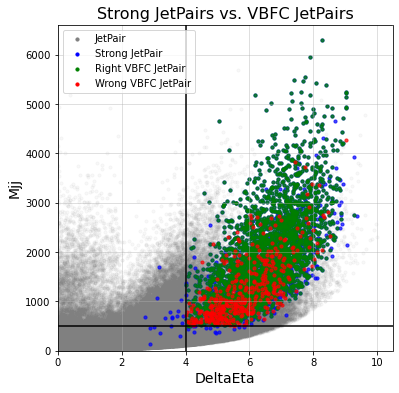

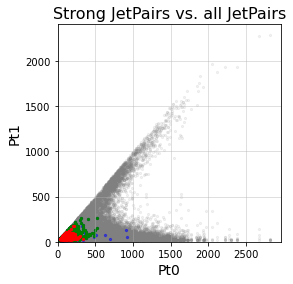

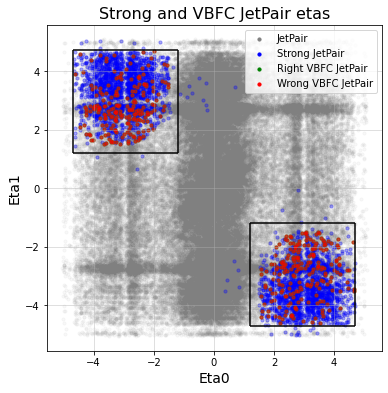

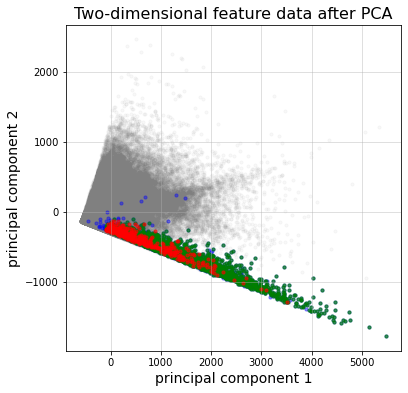

In [26]:
X = pddf_s.iloc[:,1:7]
y = pddf_s.iloc[:,7]
y2 = pddf_s.iloc[:,8]

plt.figure(figsize = (6,6))
plt.scatter(X['DeltaEta'], X['Mjj'], s=10, c='gray', alpha=0.05, label='JetPair')
plt.scatter(X['DeltaEta'][y == 1], X['Mjj'][y == 1], s=10, c='blue', alpha=0.7, label='Strong JetPair')
if viljaFiltered:
    plt.title('Strong JetPairs vs. VBFC JetPairs', fontsize=16)
    plt.scatter(X['DeltaEta'][y2 == 1][y == 1], X['Mjj'][y2 == 1][y == 1], s=10, c='green', alpha=0.7, label='Right VBFC JetPair')
    plt.scatter(X['DeltaEta'][y2 == 1][y == 0], X['Mjj'][y2 == 1][y == 0], s=10, c='red', alpha=0.7, label='Wrong VBFC JetPair')
else:
    plt.title('Strong JetPairs vs. all JetPairs', fontsize=16)
plt.xlabel('DeltaEta', fontsize=14)
plt.ylabel('Mjj', fontsize=14)
plt.xlim(0)
plt.ylim(0)
plt.grid(alpha=0.5)
plt.axvline(x=4, ymin=0, ymax=6000, c='black')
plt.axhline(y=500, xmin=0, xmax=12, c='black')

leg = plt.legend()
for lh in leg.legendHandles: 
    lh.set_alpha(1)

plt.show()
# *****************************************
X = pddf_s.iloc[:,1:7]
y = pddf_s.iloc[:,7]
y2 = pddf_s.iloc[:,8]

plt.figure(figsize = (4,4))
plt.scatter(X['Pt0'], X['Pt1'], s=5, c='gray', alpha=0.1, label='JetPair')
plt.scatter(X['Pt0'][y == 1], X['Pt1'][y == 1], s=5, c='blue', alpha=0.5, label='Strong JetPair')
if viljaFiltered:
    plt.title('Strong JetPairs vs. all JetPairs', fontsize=16)
    plt.scatter(X['Pt0'][y2 == 1][y == 1], X['Pt1'][y2 == 1][y == 1], s=5, c='green', label='Right VBFC JetPair')
    plt.scatter(X['Pt0'][y2 == 1][y == 0], X['Pt1'][y2 == 1][y == 0], s=5, c='red', label='Wrong VBFC JetPair')
plt.title('Strong JetPairs vs. all JetPairs', fontsize=16)
plt.ylim(0)
plt.xlim(0)
plt.xlabel('Pt0', fontsize=14)
plt.ylabel('Pt1', fontsize=14)
plt.grid(alpha=0.5)
plt.show()
# *****************************************
X = pddf_s.iloc[:,1:7]
y = pddf_s.iloc[:,7]


plt.figure(figsize = (6,6))
plt.scatter(X['Eta0'], X['Eta1'], s=10, c='gray', alpha=0.05, label='JetPair')
plt.scatter(X['Eta0'][y == 1], X['Eta1'][y == 1], s=10, c='blue', alpha=0.3, label='Strong JetPair')
if viljaFiltered:
    plt.title('Strong and VBFC JetPair etas', fontsize=16)
    plt.scatter(X['Eta0'][y2 == 1][y == 0], X['Eta1'][y2 == 1][y == 0], s=10, c='green', alpha=0.5, label='Right VBFC JetPair')
    plt.scatter(X['Eta0'][y2 == 1][y == 0], X['Eta1'][y2 == 1][y == 0], s=10, c='red', alpha=0.5, label='Wrong VBFC JetPair')
else:
    plt.title('Strong and all JetPair etas', fontsize=16)

plt.xlabel('Eta0', fontsize=14)
plt.ylabel('Eta1', fontsize=14)

plt.vlines(x=-4.7, ymin=1.2, ymax=4.7, color='black')
plt.vlines(x=-1.2, ymin=1.2, ymax=4.7, color='black')
plt.vlines(x=1.2, ymin=-4.7, ymax=-1.2, color='black')
plt.vlines(x=4.7, ymin=-4.7, ymax=-1.2, color='black')

plt.hlines(y=-4.7, xmin=1.2, xmax=4.7, color='black')
plt.hlines(y=-1.2, xmin=1.2, xmax=4.7, color='black')
plt.hlines(y=1.2, xmin=-4.7, xmax=-1.2, color='black')
plt.hlines(y=4.7, xmin=-4.7, xmax=-1.2, color='black')

plt.grid(alpha=0.5)

leg = plt.legend()
for lh in leg.legendHandles: 
    lh.set_alpha(1)

plt.show()
# *****************************************
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
principalX = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

plt.figure(figsize = (6,6))
plt.scatter(principalX.iloc[:,0], principalX.iloc[:,1], s=10, c='gray', alpha=0.05, label='JetPair')
plt.scatter(principalX.iloc[:,0][y == 1], principalX.iloc[:,1][y == 1], s=10, c='blue', alpha=0.4, label='Strong JetPair')
plt.title('Two-dimensional feature data after PCA', fontsize=16)
if viljaFiltered:
    plt.scatter(principalX.iloc[:,0][y2 == 1][y == 1], principalX.iloc[:,1][y2 == 1][y == 1], s=10, c='green', alpha=0.6, label='Right VBFC JetPair')
    plt.scatter(principalX.iloc[:,0][y2 == 1][y == 0], principalX.iloc[:,1][y2 == 1][y == 0], s=10, c='red', alpha=0.6, label='Wrong VBFC JetPair')
plt.xlabel('principal component 1', fontsize=14)
plt.ylabel('principal component 2', fontsize=14)
plt.grid(alpha=0.5)
plt.show()

In [27]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [28]:
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.metrics import mean_squared_error

# from sklearn.metrics import classification_report, confusion_matrix

# from sklearn.metrics import accuracy_score

In [29]:
# X = pddf_s.iloc[:,1:7]
# y = pddf_s.iloc[:,7]

# X = X.apply(zscore)

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

# X.head()

In [30]:
# classifier = KNeighborsClassifier(n_neighbors=3)
# classifier.fit(X_train, y_train)

# y_pred = classifier.predict(X_test)

# print(classification_report(y_test, y_pred))
# print('Total accuracy: ' + str(round(accuracy_score(y_test, y_pred), 4)))

# print(confusion_matrix(y_test, y_pred))

In [31]:
# classifier = KNeighborsClassifier(n_neighbors=7)
# classifier.fit(X_train, y_train)

# y_pred = classifier.predict(X_test)

# print(classification_report(y_test, y_pred))
# print('Total accuracy: ' + str(round(accuracy_score(y_test, y_pred), 4)))

# print(confusion_matrix(y_test, y_pred))

In [32]:
# classifier = KNeighborsClassifier(n_neighbors=10)
# classifier.fit(X_train, y_train)

# y_pred = classifier.predict(X_test)

# print(classification_report(y_test, y_pred))
# print('Total accuracy: ' + str(round(accuracy_score(y_test, y_pred), 4)))

# print(confusion_matrix(y_test, y_pred))

In [33]:
# accuracys=[]
# classifier = KNeighborsClassifier(n_neighbors=7)
# for i in range(100):
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
#     classifier.fit(X_train, y_train)
#     y_pred = classifier.predict(X_test)
#     accuracys.append(accuracy_score(y_test, y_pred))

In [34]:
# plt.hist(accuracys, bins=50, edgecolor='black', range=[0.97, 1])
# plt.xlabel("Accuracy", fontsize=12)
# plt.title('Histogram for 1000 accuracy results')
# plt.show()

In [35]:
# import statistics

In [36]:
# # Little statistics of the results on accuracy
# print('Minimum: ' +str(round(min(accuracys),4)))
# print('Mean:    ' +str(round(statistics.mean(accuracys),4)))
# print('Median:  ' +str(round(statistics.median(accuracys),4)))
# print('Maximum: ' +str(round(max(accuracys),4)))

In [37]:
print('Overall number of category instances:')

print('Not VBF Jet: ' + str(len(y[y==0])))
print('VBF Jet:     ' + str(len(y[y==1])))
if viljaFiltered:
    print('Wrong VBFC:  ' + str(len(y2[y2==1][y==0])))
    print('Right VBFC:  ' + str(len(y2[y2==1][y==1])))

Overall number of category instances:
Not VBF Jet: 105944
VBF Jet:     3349
Wrong VBFC:  409
Right VBFC:  2940


In [38]:
# print(classification_report(y, np.array(y2)))
# print('Total accuracy: ' + str(round(accuracy_score(y, np.array(y2)), 4)))

# print(confusion_matrix(y, np.array(y2)))

In [39]:
# X = pddf_s.iloc[:,1:7]
# y = pddf_s.iloc[:,7]

# X = X.apply(zscore)

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [40]:
#from itertools import cycle

#from sklearn import svm, datasets

#from sklearn.model_selection import train_test_split
#from sklearn.preprocessing import label_binarize
#from sklearn.multiclass import OneVsRestClassifier
#from scipy import interp
#from sklearn.metrics import roc_auc_score

Classifier: KNN(n=7):

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     21174
           1       0.77      0.71      0.74       685

    accuracy                           0.98     21859
   macro avg       0.88      0.85      0.87     21859
weighted avg       0.98      0.98      0.98     21859

Total accuracy: 0.9843
ROC score:      0.9566
Confusion matrix:
[[21027   147]
 [  196   489]]


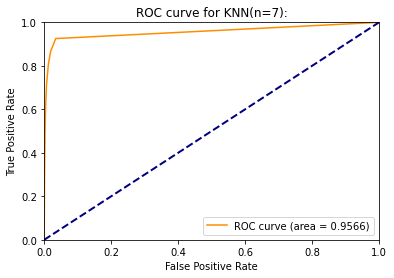

*************************************************
Classifier: LogisticRegression:

              precision    recall  f1-score   support

           0       0.98      0.99      0.99     21174
           1       0.73      0.47      0.57       685

    accuracy                           0.98     21859
   macro avg       0.86      0.73      0.78     21859
weighted avg       0.98      0.98      0.98     21859

Total accuracy: 0.9781
ROC score:      0.9812
Confusion matrix:
[[21057   117]
 [  362   323]]


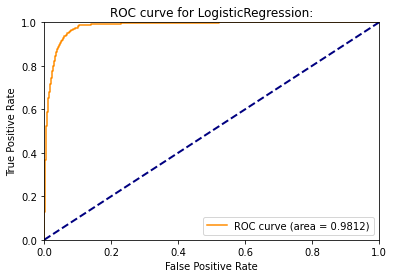

*************************************************
Classifier: MLPClassifier:



In [ ]:
classifiers = [KNeighborsClassifier(n_neighbors=7),
               LogisticRegression(random_state=0, solver='lbfgs', multi_class='ovr'),
               MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)]

names = ['KNN(n=7)','LogisticRegression','MLPClassifier']

j = 0
for classifier in classifiers:
    
    print('Classifier: ' + str(names[j]) + ':\n')
    
    
    y_proba = classifier.fit(X_train, y_train).predict_proba(X_test)
    y_pred = classifier.fit(X_train, y_train).predict(X_test)
    print(classification_report(y_test, y_pred))
    print('Total accuracy: ' + str(round(accuracy_score(y_test, y_pred), 4)))
    print('ROC score:      ' + str(round(roc_auc_score(y_test, y_proba[:, 1]), 4)))
    print('Confusion matrix:')
    print(confusion_matrix(y_test, y_pred))
    

    fpr, tpr, _ = roc_curve(y_test, y_proba[:,1])
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.4f)' %roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve for ' + names[j] + ':')
    plt.legend(loc="lower right")
    plt.show()
    j += 1
    
    print('*************************************************')

In [ ]:
t4 = time.time()
print(str(round(t4-t3)) + ' s = ' + str(round((t4-t3)/60)) + ' min ')
print(str(round(t4-t_init)) + ' s = ' + str(round((t4-t_init)/60)) + ' min ')

In [ ]:
t5 = time.time()
print(str(round(t5-t4)) + ' s = ' + str(round((t5-t4)/60)) + ' min')
print(str(round(t5-t_init)) + ' s = ' + str(round((t5-t_init)/60)) + ' min')

In [ ]:
t6 = time.time()
print(str(round(t6-t5)) + ' s = ' + str(round((t6-t5)/60)) + ' min ')
print(str(round(t6-t_init)) + ' s = ' + str(round((t6-t_init)/60)) + ' min ')

# ---------------------------------

## Examples:

In [ ]:
#printStats(df0, ['nB', 'nB_weak', 'nB_strong'])
#printStats(df0, ['nB_etaDetectable', 'nB_etaDetectable_weak', 'nB_etaDetectable_strong'])
#printStats(df0, ['nB_GenJetDetectable', 'nB_GenJetDetectable_weak', 'nB_GenJetDetectable_strong'])
#printStats(df0, ['nB_JetDetectable', 'nB_JetDetectable_weak', 'nB_JetDetectable_strong'])

In [ ]:
# printEvents(notEqualIndexList,
#             showVBFCandidates=True,
#             onlyNotWeaks=False, onlyNotWeaks_and_bigPt=False,
#             printShort=True, printIdx=False, printIdxStatus=False, printCoordinateAndPt=True)

In [ ]:
# printEvents(50,
#             showVBFCandidates=False,
#             onlyNotWeaks=True, onlyNotWeaks_and_bigPt=False,
#             printShort=True, printIdx=False, printIdxStatus=False, printCoordinateAndPt=True)

# ---------------------------------

In [ ]:
t_final = time.time()
print(str(round(t_final-t6)) + ' s = ' + str(round((t_final-t6)/60)) + ' min ')
print(str(round(t_final-t_init)) + ' s = ' + str(round((t_final-t_init)/60)) + ' min ')